In [1]:
import numpy as np
import pickle

In [2]:
with open("../deep_log_analy/BIGDAMA-data/BIGDAMA-renewdataset2.dump", "rb") as f:
    raw_data, labels, days = pickle.load(f)

In [3]:
raw_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
x = np.arange(24).reshape(2,3,4)
bases =  1

factor = []
for _ in np.arange(bases):
    tmp =[]
    for i2 in x.shape:
        tmp.append(np.ones(i2))
    factor.append(tmp)
print(np.array(factor))

dimension = 3
print(np.tile(x.shape, dimension).reshape(dimension, -1))

# def kronAlongIndex(self, factor, index):
factor = [1, 1, 1]
index = 2
element = np.array([1])
for i1 in factor[:index]:
    element = np.kron(element, i1)
for i1 in factor[index+1:]:
    element = np.kron(element, i1)
print(element)

[[array([1., 1.]) array([1., 1., 1.]) array([1., 1., 1., 1.])]]
[[2 3 4]
 [2 3 4]
 [2 3 4]]
[1]


### - basis と factor ?
### CP分解っぽい

In [43]:
class MulHelper(object):
    def __init__(self, cls, mtd_name):
        self.cls = cls
        self.mtd_name = mtd_name
        
    def __cal__(self, *args, **kwargs):
        return getattr(self.cls, self.mtd_name)(*args, **kwargs)
    
EPS = 0.000001
class NTF():
    
    def __init__(self, bases, x, costFuncType='gkld', parallelCalc=False):
        '''
        bases 基底の次元数
        x 　分解対象のテンソル
        
        '''
        self.shape = x.shape
        self.factor = self.allocateFactor(bases)
        
        dimension = len(self.shape)
        self.preshape = np.tile(self.shape, dimension).reshape(dimension, -1)
        for i1 in np.arange(dimension): # 対角成分は1
            self.preshape[i1, i1] = 1
            
        self.composeTensor = self.composeTensorSerially

        # Select update rule based on a cost function.
        if 'euclid' == costFuncType:
            self.updater = self.updateBasedOnEuclid
        elif 'gkld' == costFuncType:
            self.updater = self.updateBasedOnGKLD
        elif 'isd' == costFuncType:
            self.updater = self.updateBasedOnISD
        else:
            assert False, "\"" + costFuncType + "\" is invalid."
                
    def __getstate__(self): # for multi thread
        self_dict = self.__dict__.copy()
        del self_dict['pool']
        
    def allocateFactor(self, bases):
        factor = []
        for _ in np.arange(bases):
            tmp =[]
            for i2 in self.shape:
                tmp.append(np.ones(i2))
            factor.append(tmp)
        return np.array(factor)
    
    def updateBasedOnGKLD(self, x, factor, index):
        element = self.kronAlongIndex(factor, index)
        element = element.reshape(self.preshape[index])
        estimation = self.createTensorFromFactors()
        boost = x/(estimation + EPS)
        numer = self.sumAlongIndex(boost*element, factor, index)
        denom = np.sum(element)
        
        return numer/(denom + EPS)
    
    def kronAlongIndex(self, factor, index):
        print("kronAlongIndex:", factor, index)
        element = np.array([1])
        print("init element:", element)
        for i1 in factor[:index]:
            print(element, i1)
            element = np.kron(element, i1)
            print("\t", element)
        print("result1 element: ", element)

        for i1 in factor[index+1:]:
            element = np.kron(element, i1)
        print("result2 element: ", element)

        return element
    
    def sumAlongIndex(self, value, factor, index):
        for _ in np.arange(index):
            value = np.sum(value, axis=0)
        for _ in np.arange(index + 1, len(factor)):
            value = np.sum(value, axis=1)
        return value
    
    def createTensorFromFactors(self):
        tensor = self.composeTensor(self.factor)
        tensor = np.sum(tensor, axis=0)
        return tensor.reshape(self.shape)
    
    def composeTensorSerially(self, element):
        return list(map(self.kronAll, element))
    
    def kronAll(self, factor):
        element = np.array([1])
        for i1 in factor:
            element = np.kron(element, i1)
        return element
    
    def updateFactorEachBasis(self, x, factorPerBasis):
        for i1 in np.arange(len(factorPerBasis)):
            factorPerBasis[i1] *= self.updater(x, factorPerBasis, i1)
            
    def updateAllFactors(self, x, factor):
        for i1 in factor:
            self.updateFactorEachBasis(x, i1)
            
    def factorize(self, x, iterations=500, showProgress=False):
        for i1 in np.arange(1, iterations+1):
            self.updateAllFactors(x, self.factor)
            
    def reconstruct(self):
        return self.createTensorFromFactors()
    
    def normalizeFactor(self):
        weight = []
        for i1, fct1 in enumerate(self.factor):
            baseValue = np.array(map(np.sum, fct1))
            weight = np.append(weight, np.prod(baseValue))
            self.factor[i1] = map(lambda fct2, base: fct2/base, fct1, baseValue)
        return weight
    
    def setFactor(self, dimension, initialValue):
        assert len(initialValue) == len(self.factor)
        assert dimension < len(self.factor[0])
        assert initialValue.shape[1] == len(self.factor[0][dimension])
        for i1, value in enumerate(initialValue):
            self.factor[i1][dimension] = value + EPS
            
    def getFactor(self):
        return np.copy(self.factor)
    
    def getNormalizedFactor(sefl):
        weight = []
        normalized = []
        for fct in self.factor: 
            baseValue = np.empty(len(fct))
            for i1 in np.arange(len(fct)):
                baseValue[i1] = np.sum(fct[i1])
            weight = np.append(weight, np.prod(baseValue))
            tmp = []
            for fct2, base in zip(fct, baseValue):
                tmp.append(fct2/base)
            normalized.append(tmp)
        return weight, np.array(normalized)

In [44]:
test = np.arange(24).reshape(2, 3, 4)
# test = np.arange(6).reshape(1, 2, 3)
ntf = NTF(1, test)
ntf.factorize(test)
print(ntf.reconstruct())

kronAlongIndex: [array([1., 1.]) array([1., 1., 1.]) array([1., 1., 1., 1.])] 0
init element: [1]
result1 element:  [1]
result2 element:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
kronAlongIndex: [array([ 5.49999404, 17.49998104]) array([1., 1., 1.])
 array([1., 1., 1., 1.])] 1
init element: [1]
[1] [ 5.49999404 17.49998104]
	 [ 5.49999404 17.49998104]
result1 element:  [ 5.49999404 17.49998104]
result2 element:  [ 5.49999404  5.49999404  5.49999404  5.49999404 17.49998104 17.49998104
 17.49998104 17.49998104]
kronAlongIndex: [array([ 5.49999404, 17.49998104])
 array([0.65217457, 1.00000099, 1.3478274 ]) array([1., 1., 1., 1.])] 2
init element: [1]
[1] [ 5.49999404 17.49998104]
	 [ 5.49999404 17.49998104]
[ 5.49999404 17.49998104] [0.65217457 1.00000099 1.3478274 ]
	 [ 3.58695623  5.49999946  7.41304269 11.41304256 17.49999829 23.58695402]
result1 element:  [ 3.58695623  5.49999946  7.41304269 11.41304256 17.49999829 23.58695402]
result2 element:  [ 3.58695623  5.49999946  7.41304269 11.41

 array([0.8695651 , 0.95652161, 1.04347813, 1.13043464])] 1
init element: [1]
[1] [ 5.49997961 17.4999369 ]
	 [ 5.49997961 17.4999369 ]
result1 element:  [ 5.49997961 17.4999369 ]
result2 element:  [ 4.78259031  5.26084936  5.73910841  6.21736747 15.21733437 16.73906785
 18.26080135 19.78253486]
kronAlongIndex: [array([ 5.49997961, 17.4999369 ])
 array([0.65217629, 1.00000366, 1.34783105])
 array([0.8695651 , 0.95652161, 1.04347813, 1.13043464])] 2
init element: [1]
[1] [ 5.49997961 17.4999369 ]
	 [ 5.49997961 17.4999369 ]
[ 5.49997961 17.4999369 ] [0.65217629 1.00000366 1.34783105]
	 [ 3.5869563   5.49999976  7.41304327 11.41304393 17.50000101 23.58695826]
result1 element:  [ 3.5869563   5.49999976  7.41304327 11.41304393 17.50000101 23.58695826]
result2 element:  [ 3.5869563   5.49999976  7.41304327 11.41304393 17.50000101 23.58695826]
kronAlongIndex: [array([ 5.49997961, 17.4999369 ])
 array([0.65217629, 1.00000366, 1.34783105])
 array([0.8695651 , 0.95652161, 1.04347812, 1.13043464

kronAlongIndex: [array([ 5.49996825, 17.49990076])
 array([0.65217771, 1.00000584, 1.34783398])
 array([0.869565  , 0.95652151, 1.04347801, 1.13043452])] 2
init element: [1]
[1] [ 5.49996825 17.49990076]
	 [ 5.49996825 17.49990076]
[ 5.49996825 17.49990076] [0.65217771 1.00000584 1.34783398]
	 [ 3.58695669  5.50000036  7.41304407 11.41304517 17.50000292 23.58696083]
result1 element:  [ 3.58695669  5.50000036  7.41304407 11.41304517 17.50000292 23.58696083]
result2 element:  [ 3.58695669  5.50000036  7.41304407 11.41304517 17.50000292 23.58696083]
kronAlongIndex: [array([ 5.49996825, 17.49990076])
 array([0.65217771, 1.00000584, 1.34783398])
 array([0.869565  , 0.9565215 , 1.04347801, 1.13043451])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56711091 0.623822   0.6805331  0.73724419 0.86957008 0.95652709
 1.0434841  1.13044111 1.17202925 1.28923218 1.40643511 1.52363804]
kronAlongIndex: [array([ 5.49996787, 17.49989956])
 array([0.65217771, 1.00000584, 1.34783398])
 a

result1 element:  [ 3.58695713  5.50000103  7.41304499 11.41304658 17.50000507 23.58696373]
result2 element:  [ 3.58695713  5.50000103  7.41304499 11.41304658 17.50000507 23.58696373]
kronAlongIndex: [array([ 5.49995538, 17.4998598 ])
 array([0.65217931, 1.0000083 , 1.3478373 ])
 array([0.86956489, 0.95652139, 1.04347788, 1.13043437])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56711224 0.62382346 0.68053469 0.73724592 0.86957211 0.95652933
 1.04348654 1.13044376 1.172032   1.2892352  1.4064384  1.52364161]
kronAlongIndex: [array([ 5.499955 , 17.4998586])
 array([0.65217931, 1.0000083 , 1.3478373 ])
 array([0.86956489, 0.95652139, 1.04347788, 1.13043437])] 1
init element: [1]
[1] [ 5.499955  17.4998586]
	 [ 5.499955  17.4998586]
result1 element:  [ 5.499955  17.4998586]
result2 element:  [ 4.78256779  5.26082458  5.73908138  6.21733818 15.21726269 16.73898901
 18.26071534 19.78244169]
kronAlongIndex: [array([ 5.499955 , 17.4998586])
 array([0.65217936, 1.00000837, 1

 array([0.8695648 , 0.95652128, 1.04347777, 1.13043425])] 2
init element: [1]
[1] [ 5.49994364 17.49982246]
	 [ 5.49994364 17.49982246]
[ 5.49994364 17.49982246] [0.65218078 1.00001055 1.34784032]
	 [ 3.58695753  5.50000165  7.41304582 11.41304786 17.50000704 23.58696638]
result1 element:  [ 3.58695753  5.50000165  7.41304582 11.41304786 17.50000704 23.58696638]
result2 element:  [ 3.58695753  5.50000165  7.41304582 11.41304786 17.50000704 23.58696638]
kronAlongIndex: [array([ 5.49994364, 17.49982246])
 array([0.65218078, 1.00001055, 1.34784032])
 array([0.8695648 , 0.95652128, 1.04347776, 1.13043425])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56711345 0.62382479 0.68053614 0.73724749 0.86957397 0.95653137
 1.04348877 1.13044617 1.1720345  1.28923795 1.40644141 1.52364486]
kronAlongIndex: [array([ 5.49994326, 17.49982125])
 array([0.65218078, 1.00001055, 1.34784032])
 array([0.8695648 , 0.95652128, 1.04347776, 1.13043425])] 1
init element: [1]
[1] [ 5.49994326 17.

init element: [1]
[1] [ 5.49993039 17.49978029]
	 [ 5.49993039 17.49978029]
result1 element:  [ 5.49993039 17.49978029]
result2 element:  [ 4.78254526  5.2607998   5.73905435  6.2173089  15.21719102 16.73891017
 18.26062933 19.78234851]
kronAlongIndex: [array([ 5.49993039, 17.49978029])
 array([0.65218243, 1.00001308, 1.34784374])
 array([0.86956469, 0.95652116, 1.04347763, 1.13043411])] 2
init element: [1]
[1] [ 5.49993039 17.49978029]
	 [ 5.49993039 17.49978029]
[ 5.49993039 17.49978029] [0.65218243 1.00001308 1.34784374]
	 [ 3.58695799  5.50000235  7.41304676 11.41304931 17.50000926 23.58696937]
result1 element:  [ 3.58695799  5.50000235  7.41304676 11.41304931 17.50000926 23.58696937]
result2 element:  [ 3.58695799  5.50000235  7.41304676 11.41304931 17.50000926 23.58696937]
kronAlongIndex: [array([ 5.49993039, 17.49978029])
 array([0.65218243, 1.00001308, 1.34784374])
 array([0.86956469, 0.95652116, 1.04347763, 1.1304341 ])] 0
init element: [1]
result1 element:  [1]
result2 elemen

[1] [ 5.49991903 17.49974415]
	 [ 5.49991903 17.49974415]
result1 element:  [ 5.49991903 17.49974415]
result2 element:  [ 4.78253486  5.26078837  5.73904187  6.21729538 15.21715794 16.73887378
 18.26058964 19.78230551]
kronAlongIndex: [array([ 5.49991903, 17.49974415])
 array([0.65218385, 1.00001526, 1.34784667])
 array([0.86956459, 0.95652106, 1.04347752, 1.13043398])] 2
init element: [1]
[1] [ 5.49991903 17.49974415]
	 [ 5.49991903 17.49974415]
[ 5.49991903 17.49974415] [0.65218385 1.00001526 1.34784667]
	 [ 3.58695838  5.50000295  7.41304757 11.41305055 17.50001116 23.58697194]
result1 element:  [ 3.58695838  5.50000295  7.41304757 11.41305055 17.50001116 23.58697194]
result2 element:  [ 3.58695838  5.50000295  7.41304757 11.41305055 17.50001116 23.58697194]
kronAlongIndex: [array([ 5.49991903, 17.49974415])
 array([0.65218385, 1.00001526, 1.34784667])
 array([0.86956459, 0.95652105, 1.04347752, 1.13043398])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56711598 0.

[ 5.49990616 17.49970319] [0.65218546 1.00001772 1.34784999]
	 [ 3.58695882  5.50000362  7.41304848 11.41305195 17.50001331 23.58697484]
result1 element:  [ 3.58695882  5.50000362  7.41304848 11.41305195 17.50001331 23.58697484]
result2 element:  [ 3.58695882  5.50000362  7.41304848 11.41305195 17.50001331 23.58697484]
kronAlongIndex: [array([ 5.49990616, 17.49970319])
 array([0.65218546, 1.00001772, 1.34784999])
 array([0.86956448, 0.95652094, 1.04347739, 1.13043384])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56711731 0.62382905 0.68054078 0.73725251 0.86957989 0.95653789
 1.04349588 1.13045387 1.17204249 1.28924674 1.40645099 1.52365525]
kronAlongIndex: [array([ 5.49990578, 17.49970199])
 array([0.65218546, 1.00001772, 1.34784999])
 array([0.86956448, 0.95652094, 1.04347739, 1.13043384])] 1
init element: [1]
[1] [ 5.49990578 17.49970199]
	 [ 5.49990578 17.49970199]
result1 element:  [ 5.49990578 17.49970199]
result2 element:  [ 4.78252273  5.26077502  5.73902732

 array([0.86956439, 0.95652084, 1.04347728, 1.13043372])] 1
init element: [1]
[1] [ 5.4998948  17.49966705]
	 [ 5.4998948  17.49966705]
result1 element:  [ 5.4998948  17.49966705]
result2 element:  [ 4.78251268  5.26076397  5.73901526  6.21726655 15.21708737 16.73879615
 18.26050495 19.78221376]
kronAlongIndex: [array([ 5.4998948 , 17.49966705])
 array([0.65218688, 1.0000199 , 1.34785292])
 array([0.86956439, 0.95652084, 1.04347728, 1.13043372])] 2
init element: [1]
[1] [ 5.4998948  17.49966705]
	 [ 5.4998948  17.49966705]
[ 5.4998948  17.49966705] [0.65218688 1.0000199  1.34785292]
	 [ 3.58695921  5.50000422  7.41304928 11.41305319 17.50001522 23.58697741]
result1 element:  [ 3.58695921  5.50000422  7.41304928 11.41305319 17.50001522 23.58697741]
result2 element:  [ 3.58695921  5.50000422  7.41304928 11.41305319 17.50001522 23.58697741]
kronAlongIndex: [array([ 5.4998948 , 17.49966705])
 array([0.65218688, 1.0000199 , 1.34785292])
 array([0.86956439, 0.95652083, 1.04347727, 1.13043372

kronAlongIndex: [array([ 5.49988193, 17.4996261 ])
 array([0.65218848, 1.00002236, 1.34785624])
 array([0.86956429, 0.95652072, 1.04347715, 1.13043358])] 2
init element: [1]
[1] [ 5.49988193 17.4996261 ]
	 [ 5.49988193 17.4996261 ]
[ 5.49988193 17.4996261 ] [0.65218848 1.00002236 1.34785624]
	 [ 3.58695965  5.5000049   7.4130502  11.4130546  17.50001737 23.58698031]
result1 element:  [ 3.58695965  5.5000049   7.4130502  11.4130546  17.50001737 23.58698031]
result2 element:  [ 3.58695965  5.5000049   7.4130502  11.4130546  17.50001737 23.58698031]
kronAlongIndex: [array([ 5.49988193, 17.4996261 ])
 array([0.65218848, 1.00002236, 1.34785624])
 array([0.86956428, 0.95652071, 1.04347715, 1.13043358])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56711981 0.62383179 0.68054378 0.73725576 0.86958373 0.9565421
 1.04350048 1.13045885 1.17204765 1.28925242 1.40645719 1.52366196]
kronAlongIndex: [array([ 5.49988155, 17.49962489])
 array([0.65218848, 1.00002236, 1.34785624])
 ar

init element: [1]
result1 element:  [1]
result2 element:  [0.56712094 0.62383304 0.68054514 0.73725723 0.86958546 0.95654401
 1.04350256 1.13046111 1.17204999 1.28925499 1.40646    1.523665  ]
kronAlongIndex: [array([ 5.49987057, 17.49958996])
 array([0.65218985, 1.00002446, 1.34785908])
 array([0.86956419, 0.95652061, 1.04347704, 1.13043346])] 1
init element: [1]
[1] [ 5.49987057 17.49958996]
	 [ 5.49987057 17.49958996]
result1 element:  [ 5.49987057 17.49958996]
result2 element:  [ 4.7824905   5.26073957  5.73898864  6.21723772 15.2170168  16.73871853
 18.26042027 19.78212202]
kronAlongIndex: [array([ 5.49987057, 17.49958996])
 array([0.6521899 , 1.00002453, 1.34785917])
 array([0.86956419, 0.95652061, 1.04347704, 1.13043346])] 2
init element: [1]
[1] [ 5.49987057 17.49958996]
	 [ 5.49987057 17.49958996]
[ 5.49987057 17.49958996] [0.6521899  1.00002453 1.34785917]
	 [ 3.58696004  5.5000055   7.413051   11.41305584 17.50001927 23.58698287]
result1 element:  [ 3.58696004  5.5000055   7

kronAlongIndex: [array([ 5.4998577, 17.499549 ])
 array([0.65219151, 1.000027  , 1.3478625 ])
 array([0.86956408, 0.9565205 , 1.04347691, 1.13043332])] 2
init element: [1]
[1] [ 5.4998577 17.499549 ]
	 [ 5.4998577 17.499549 ]
[ 5.4998577 17.499549 ] [0.65219151 1.000027   1.3478625 ]
	 [ 3.58696048  5.50000617  7.41305192 11.41305724 17.50002143 23.58698578]
result1 element:  [ 3.58696048  5.50000617  7.41305192 11.41305724 17.50002143 23.58698578]
result2 element:  [ 3.58696048  5.50000617  7.41305192 11.41305724 17.50002143 23.58698578]
kronAlongIndex: [array([ 5.4998577, 17.499549 ])
 array([0.65219151, 1.000027  , 1.3478625 ])
 array([0.86956408, 0.95652049, 1.0434769 , 1.13043332])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56712231 0.62383454 0.68054678 0.73725901 0.86958756 0.95654632
 1.04350507 1.13046383 1.17205281 1.2892581  1.40646338 1.52366867]
kronAlongIndex: [array([ 5.49985732, 17.49954779])
 array([0.65219151, 1.000027  , 1.3478625 ])
 array([0.86

	 [ 5.49984634 17.49951286]
result1 element:  [ 5.49984634 17.49951286]
result2 element:  [ 4.78246833  5.26071517  5.73896203  6.21720888 15.21694623 16.7386409
 18.26033559 19.78203028]
kronAlongIndex: [array([ 5.49984634, 17.49951286])
 array([0.65219293, 1.00002917, 1.34786543])
 array([0.86956399, 0.95652039, 1.04347679, 1.1304332 ])] 2
init element: [1]
[1] [ 5.49984634 17.49951286]
	 [ 5.49984634 17.49951286]
[ 5.49984634 17.49951286] [0.65219293 1.00002917 1.34786543]
	 [ 3.58696087  5.50000677  7.41305272 11.41305848 17.50002333 23.58698834]
result1 element:  [ 3.58696087  5.50000677  7.41305272 11.41305848 17.50002333 23.58698834]
result2 element:  [ 3.58696087  5.50000677  7.41305272 11.41305848 17.50002333 23.58698834]
kronAlongIndex: [array([ 5.49984634, 17.49951286])
 array([0.65219293, 1.00002917, 1.34786543])
 array([0.86956399, 0.95652039, 1.04347679, 1.13043319])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56712348 0.62383583 0.68054818 0.73726053 

result1 element:  [ 3.58696131  5.50000745  7.41305364 11.41305989 17.50002549 23.58699125]
result2 element:  [ 3.58696131  5.50000745  7.41305364 11.41305989 17.50002549 23.58699125]
kronAlongIndex: [array([ 5.49983346, 17.4994719 ])
 array([0.65219453, 1.00003163, 1.34786875])
 array([0.86956388, 0.95652027, 1.04347666, 1.13043305])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56712481 0.62383729 0.68054977 0.73726226 0.86959139 0.95655053
 1.04350967 1.13046882 1.17205798 1.28926378 1.40646958 1.52367538]
kronAlongIndex: [array([ 5.49983309, 17.4994707 ])
 array([0.65219453, 1.00003163, 1.34786875])
 array([0.86956388, 0.95652027, 1.04347666, 1.13043305])] 1
init element: [1]
[1] [ 5.49983309 17.4994707 ]
	 [ 5.49983309 17.4994707 ]
result1 element:  [ 5.49983309 17.4994707 ]
result2 element:  [ 4.7824562   5.26070183  5.73894747  6.21719312 15.21690763 16.73859845
 18.26028928 19.78198011]
kronAlongIndex: [array([ 5.49983309, 17.4994707 ])
 array([0.65219458, 1.0

	 [ 5.49982211 17.49943576]
[ 5.49982211 17.49943576] [0.65219595 1.00003381 1.34787168]
	 [ 3.5869617   5.50000805  7.41305444 11.41306113 17.50002739 23.58699381]
result1 element:  [ 3.5869617   5.50000805  7.41305444 11.41306113 17.50002739 23.58699381]
result2 element:  [ 3.5869617   5.50000805  7.41305444 11.41306113 17.50002739 23.58699381]
kronAlongIndex: [array([ 5.49982211, 17.49943576])
 array([0.65219595, 1.00003381, 1.34787168])
 array([0.86956379, 0.95652017, 1.04347655, 1.13043293])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56712598 0.62383858 0.68055118 0.73726378 0.86959318 0.95655251
 1.04351183 1.13047115 1.1720604  1.28926644 1.40647248 1.52367853]
kronAlongIndex: [array([ 5.49982173, 17.49943456])
 array([0.65219595, 1.00003381, 1.34787168])
 array([0.86956379, 0.95652017, 1.04347655, 1.13043293])] 1
init element: [1]
[1] [ 5.49982173 17.49943456]
	 [ 5.49982173 17.49943456]
result1 element:  [ 5.49982173 17.49943456]
result2 element:  [ 4.7824

 array([0.86956368, 0.95652005, 1.04347642, 1.13043279])] 0
init element: [1]
result1 element:  [1]
result2 element:  [0.56712731 0.62384004 0.68055277 0.73726551 0.86959522 0.95655474
 1.04351427 1.1304738  1.17206314 1.28926946 1.40647578 1.5236821 ]
kronAlongIndex: [array([ 5.49980886, 17.4993936 ])
 array([0.65219756, 1.00003627, 1.347875  ])
 array([0.86956368, 0.95652005, 1.04347642, 1.13043279])] 1
init element: [1]
[1] [ 5.49980886 17.4993936 ]
	 [ 5.49980886 17.4993936 ]
result1 element:  [ 5.49980886 17.4993936 ]
result2 element:  [ 4.78243402  5.26067744  5.73892086  6.21716428 15.21683707 16.73852082
 18.26020459 19.78188837]
kronAlongIndex: [array([ 5.49980886, 17.4993936 ])
 array([0.6521976 , 1.00003634, 1.34787509])
 array([0.86956368, 0.95652005, 1.04347642, 1.13043279])] 2
init element: [1]
[1] [ 5.49980886 17.4993936 ]
	 [ 5.49980886 17.4993936 ]
[ 5.49980886 17.4993936 ] [0.6521976  1.00003634 1.34787509]
	 [ 3.58696216  5.50000874  7.41305538 11.41306258 17.5000296

In [45]:
import numpy as np

class Tucker:
    def __init__(self,R,S,T,max_iter):
        self.latent_size = (R,S,T)
        self.max_iter=max_iter

    def _calc_data_shape(self,X):
        max_i = -1
        max_j = -1
        max_k = -1
        for i,j,k in X:
            if max_i<i: max_i=i
            if max_j<j: max_j=j
            if max_k<k: max_k=k
        return (max_i+1,max_j+1,max_k+1)

    def _calc_core_tensor(self,X):
        G = np.zeros(shape=self.latent_size)
        for a in range(self.latent_size[0]):
            for b in range(self.latent_size[1]):
                for c in range(self.latent_size[2]):
                    for indices in X:
                        i,j,k = indices
                        G[a,b,c] += X[indices]*self.A[0][i,a]*self.A[1][j,b]*self.A[2][k,c]
        return G

    def _init_latent_vectors(self):
        A = {}
        for m in range(3):
            A[m] = np.random.normal(loc=0, scale=0.1, size=(self.data_shape[m],self.latent_size[m]))
        return A

    def _loss(self,X):
        G = self._calc_core_tensor(X)
        return - (G**2).sum() / (G.shape[0]*G.shape[1]*G.shape[2])

    def _update(self,X,modes): # modes = [0, 1, 2 ]の場合
        row = self.data_shape[modes[0]]
        # Rの方向に対応する元テンソルのながさ
        
        col = self.A[modes[1]].shape[1] * self.A[modes[2]].shape[1]
        # S,T方向はunfoldする． self.A[modes[1]] はS方向のmatrixで，shape[1]で削減後の次元
        # S, T の積がcol???  
        
        X_bar = np.zeros(shape=(row,col))
        for indices in X:
            for a in range(self.latent_size[modes[1]]):
                for b in range(self.latent_size[modes[2]]):
                    q = a*self.latent_size[modes[2]]+b
                    X_bar[indices[modes[0]],q] += X[indices] * self.A[modes[1]][indices[modes[1]],a] * self.A[modes[2]][indices[modes[2]],b]
        U,s,V = np.linalg.svd(X_bar)
        return U[:,:self.latent_size[modes[0]]]

    def fit(self,X):
        self.data_shape = self._calc_data_shape(X)
        self.A = self._init_latent_vectors()
        self._losses = []
        remained_iter = self.max_iter
        while remained_iter>0:
            self.A[0] = self._update(X,(0,1,2)) # mode 1 = R の方向をupdate
            self.A[1] = self._update(X,(1,2,0)) # Sの方向
            self.A[2] = self._update(X,(2,0,1)) # Tの方向
            remained_iter-=1
            l = self._loss(X)
            self._losses.append(l)
        self.G = self._calc_core_tensor(X)
        return self

    def predict(self,indices):
        i,j,k = indices
        ret = np.tensordot(
                np.tensordot(
                    np.tensordot(self.G,
                        self.A[2][k], axes=(2,0)),
                    self.A[1][j], axes=(1,0)),
                self.A[0][i], axes=(0,0))
        return ret

In [46]:
model = Tucker(R=5,S=10,T=15,max_iter=5)

In [47]:
""" Make test data """
true_R = 5
true_S = 10
true_T = 15
true_U = np.random.normal(loc=0.0, scale=1, size=(10,true_R))
true_V = np.random.normal(loc=0.0, scale=1, size=(15,true_S))
true_W = np.random.normal(loc=0.0, scale=1, size=(20,true_T))
true_G = np.random.normal(loc=0.0, scale=1, size=(true_R, true_S, true_T))
X = {}
for i in range(true_U.shape[0]):
    for j in range(true_V.shape[0]):
        for k in range(true_W.shape[0]):
            X[(i,j,k)]=0
            for r in range(true_R):
                for s in range(true_S):
                    for t in range(true_T):
                        X[(i,j,k)] += true_G[r,s,t]*true_U[i,r]*true_V[j,s]*true_W[k,t]
            X[(i,j,k)] += np.random.normal(loc=0, scale=0.1)

In [48]:
model.fit(X)


In [50]:

residual  = 0
count = 0
for indices in X:
    residual += abs(X[indices]-model.predict(indices))
    count += 1
print(residual/count)

0.06599872430132


In [52]:
model.G.shape

(5, 10, 15)

### とりあえずmatrixでやってみる

In [4]:
from sklearn.decomposition import NMF

In [5]:
raw_data.shape

(54720, 1440)

In [10]:
reshaped_data = raw_data.reshape(int(54720/456), -1)[: , 131040:]

In [11]:
reshaped_data.shape

(120, 525600)

In [12]:
model = NMF(n_components=20, init='random', random_state=0, solver="mu", verbose=True)
P = model.fit_transform(reshaped_data)
Q = model.components_

Epoch 10 reached after 9.610 seconds, error: 1119.424337
Epoch 20 reached after 18.963 seconds, error: 986.204998
Epoch 30 reached after 28.668 seconds, error: 863.400347
Epoch 40 reached after 38.370 seconds, error: 850.076643
Epoch 50 reached after 48.015 seconds, error: 743.251158
Epoch 60 reached after 57.856 seconds, error: 732.222845
Epoch 70 reached after 67.378 seconds, error: 731.495117
Epoch 80 reached after 76.657 seconds, error: 731.349799


In [13]:
P.shape

(120, 20)

In [14]:
Q.shape

(20, 525600)

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

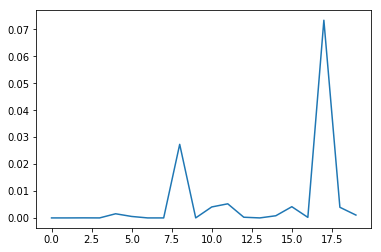

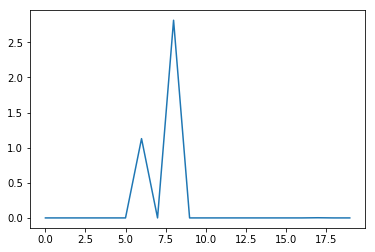

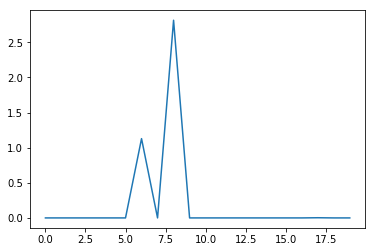

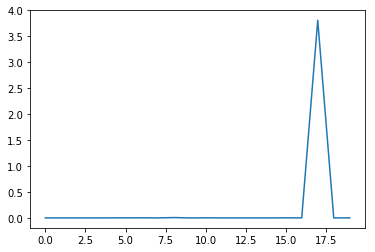

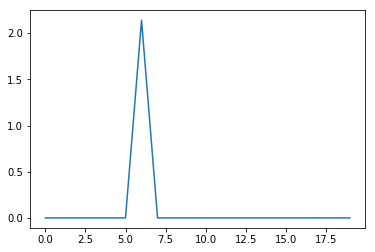

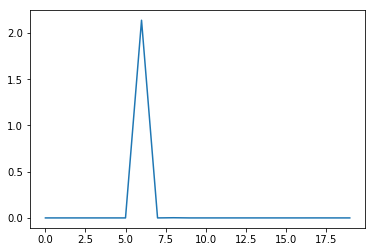

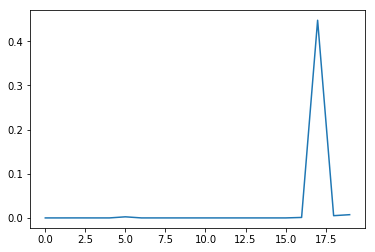

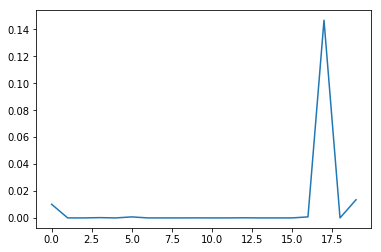

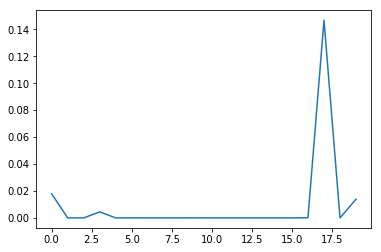

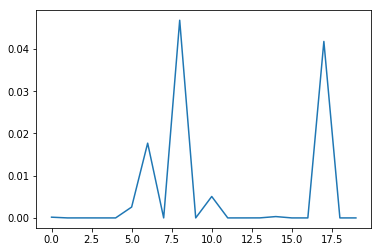

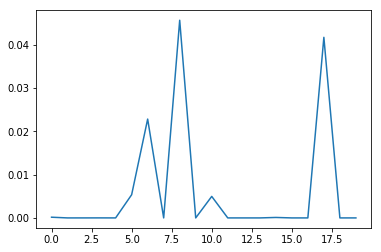

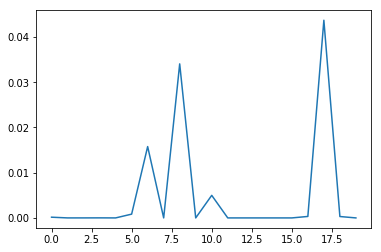

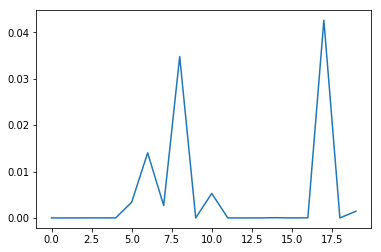

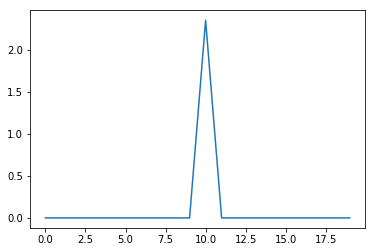

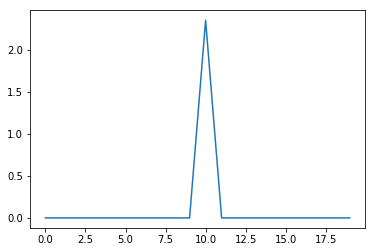

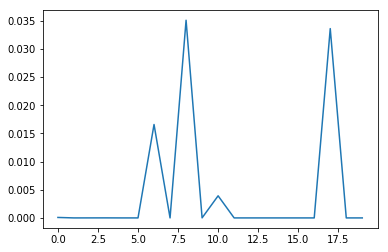

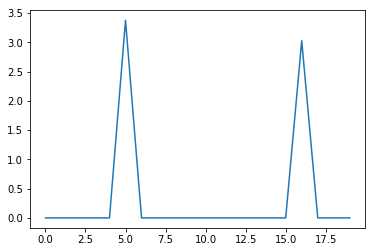

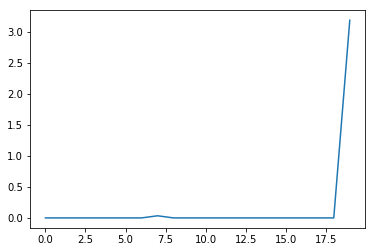

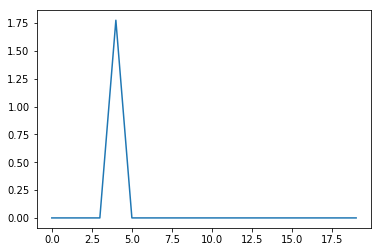

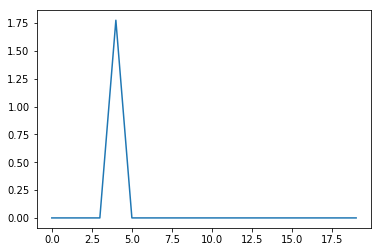

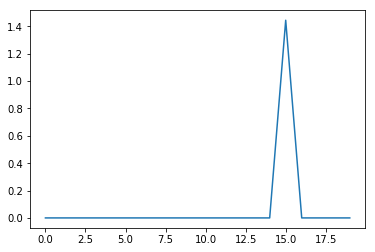

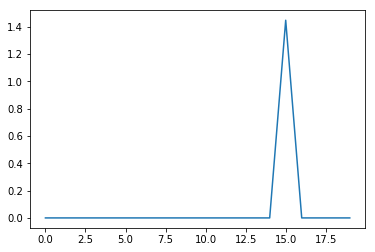

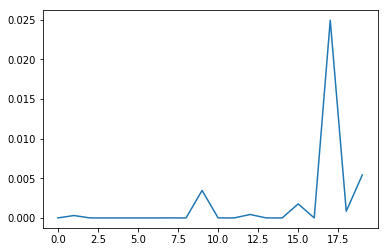

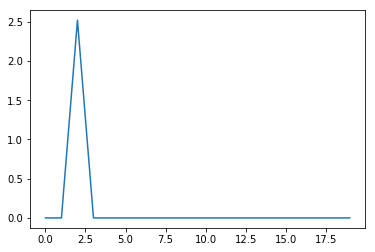

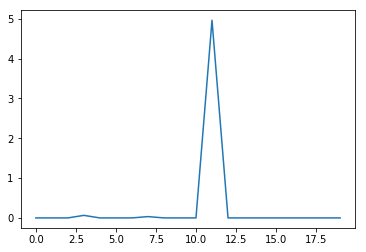

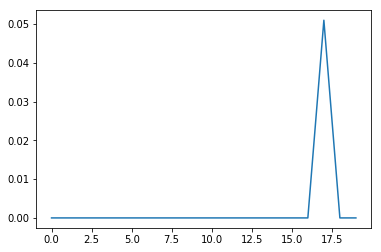

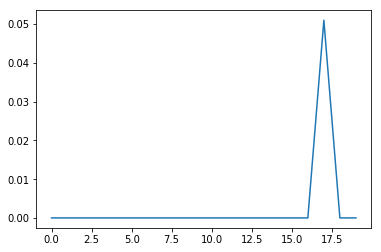

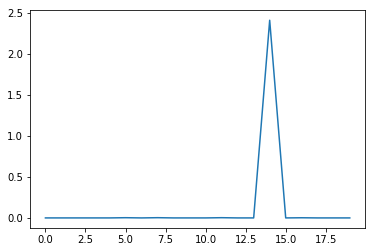

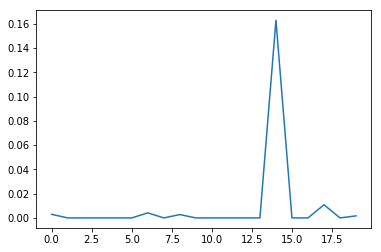

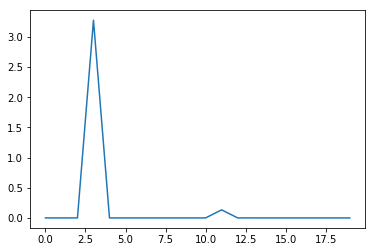

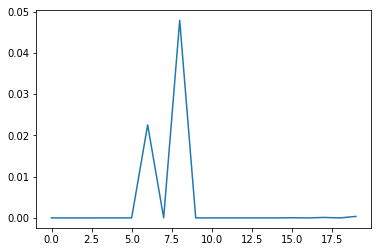

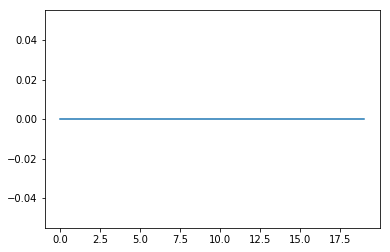

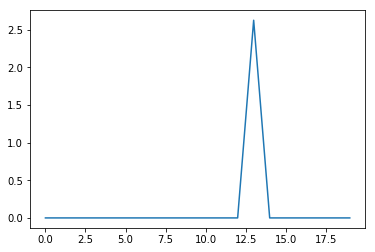

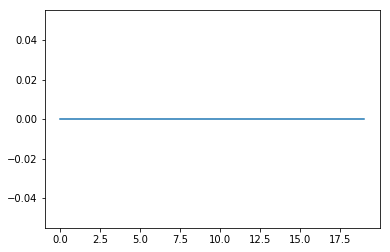

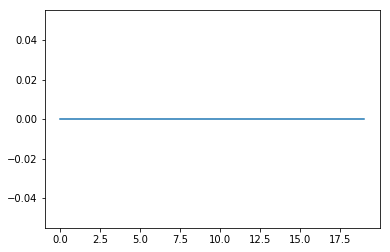

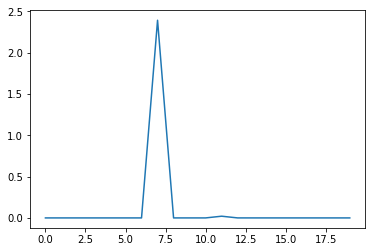

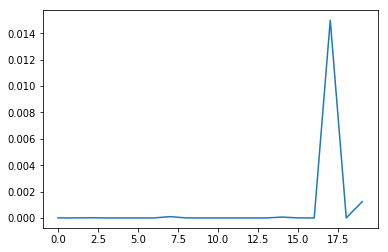

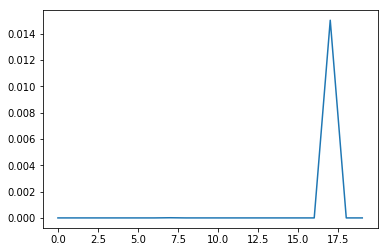

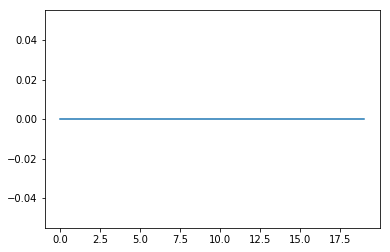

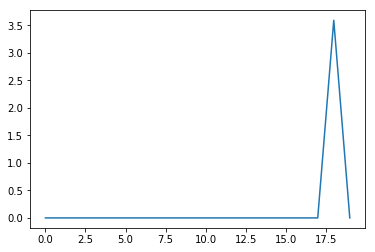

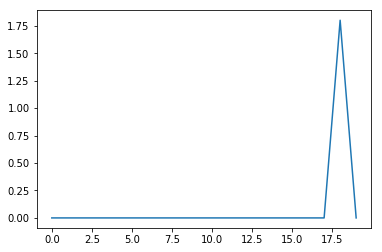

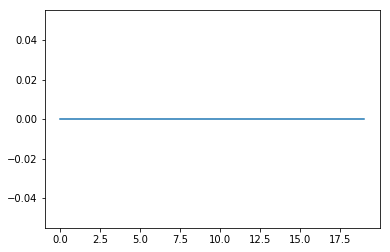

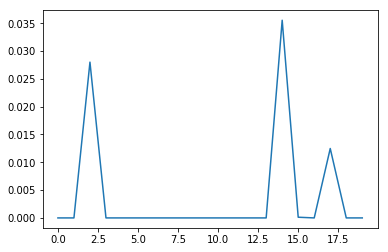

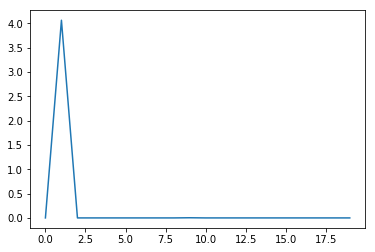

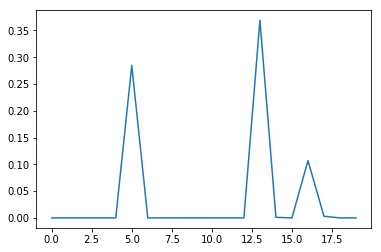

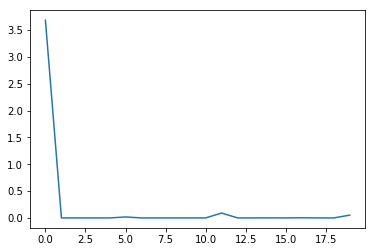

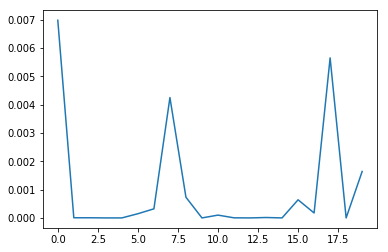

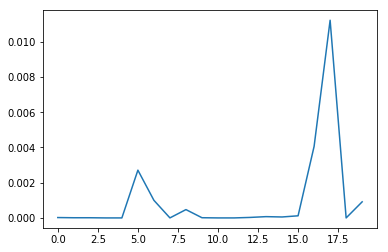

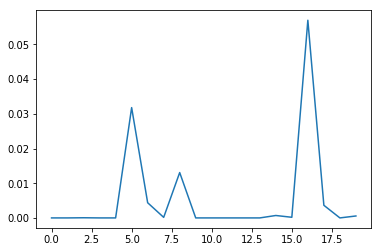

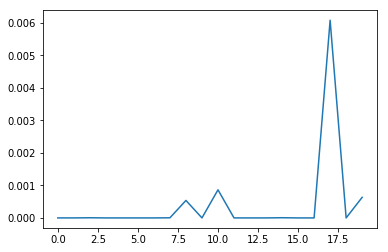

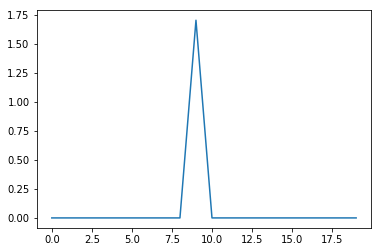

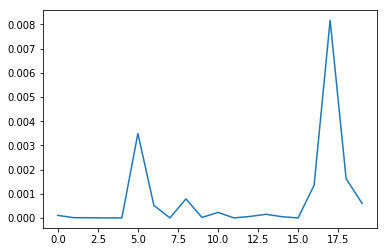

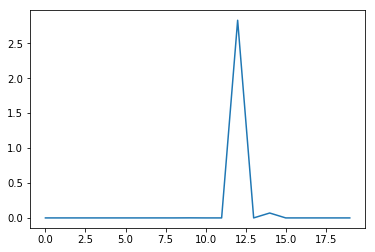

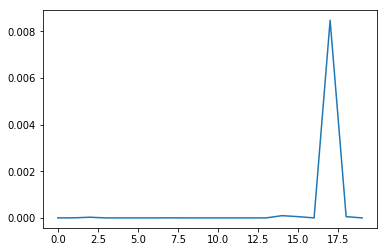

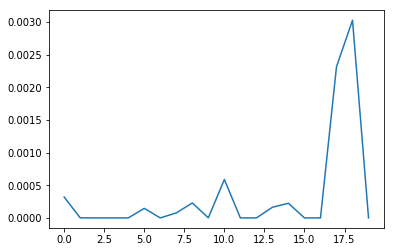

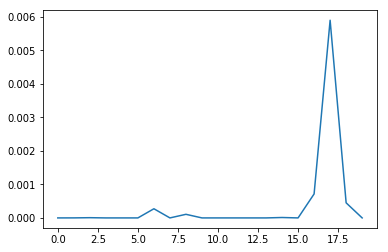

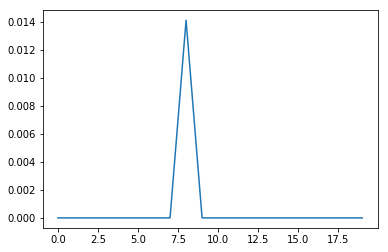

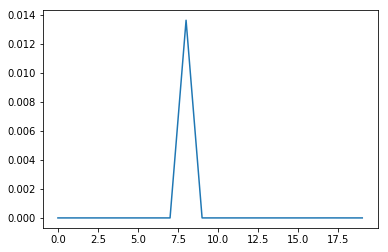

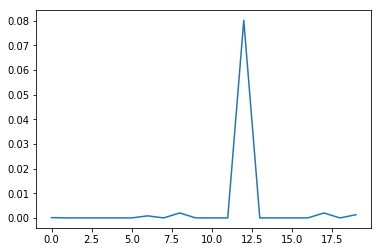

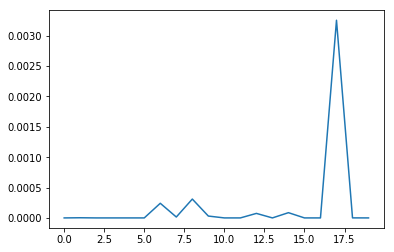

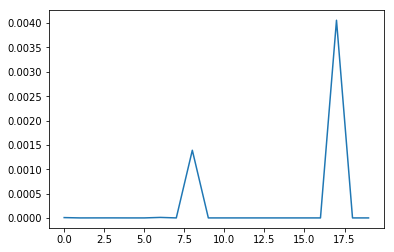

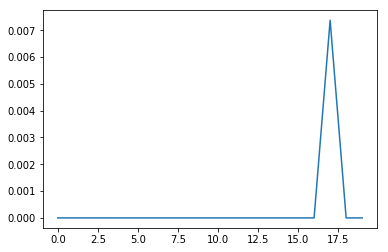

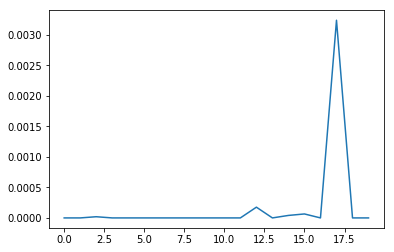

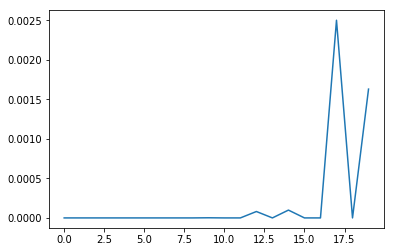

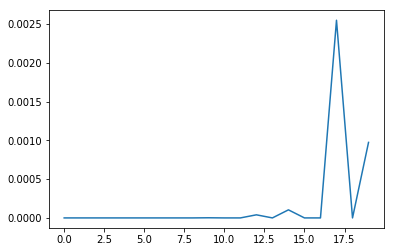

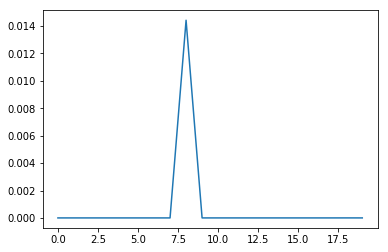

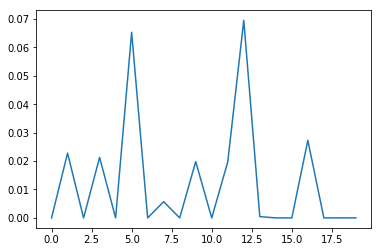

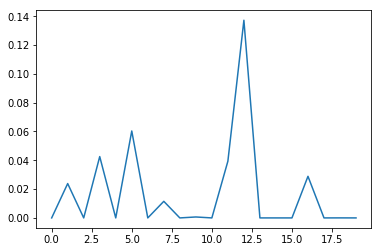

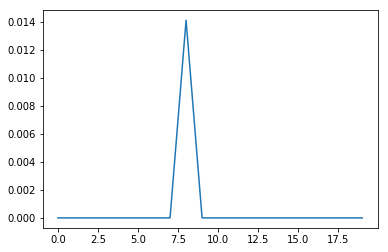

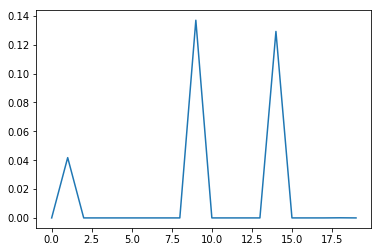

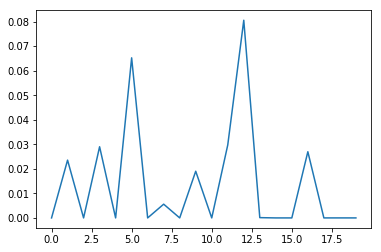

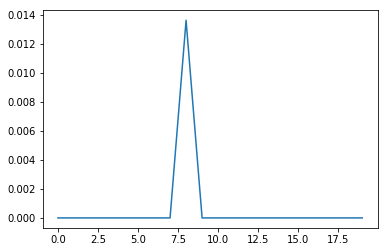

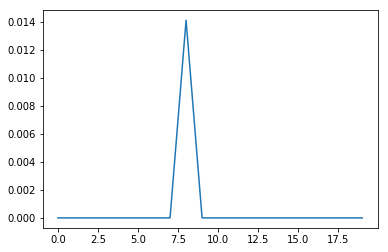

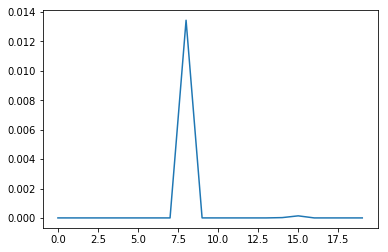

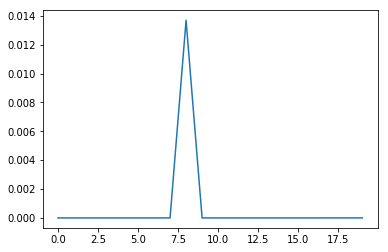

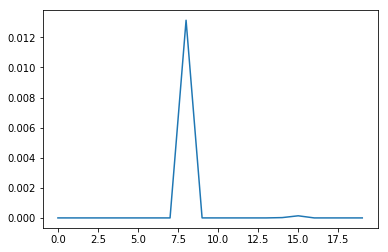

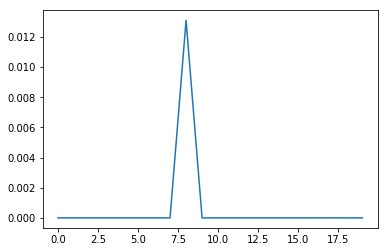

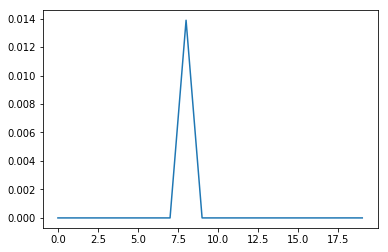

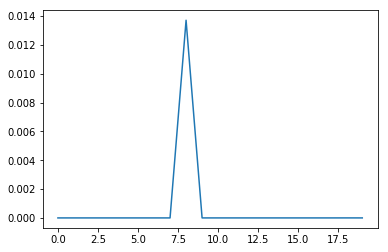

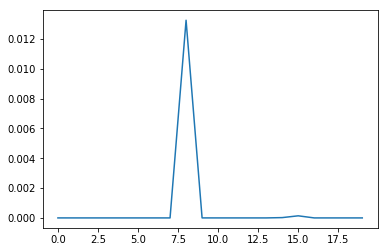

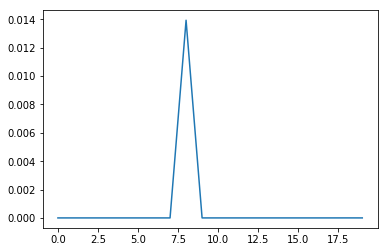

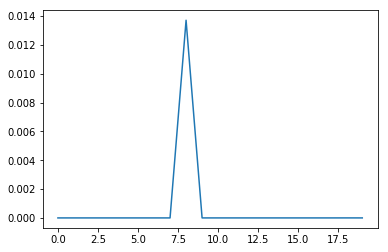

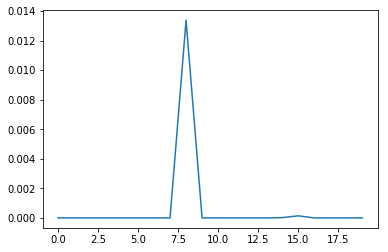

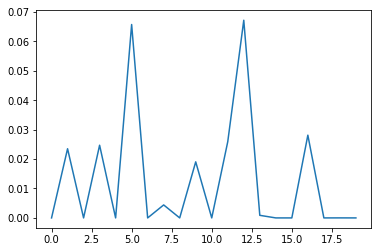

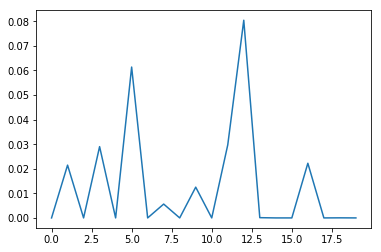

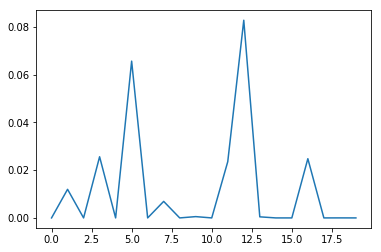

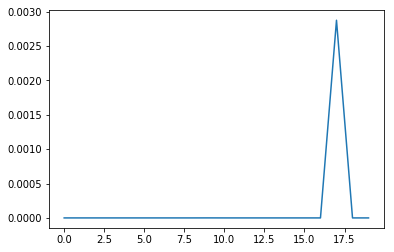

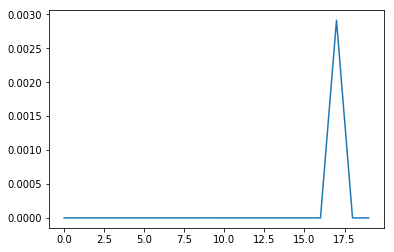

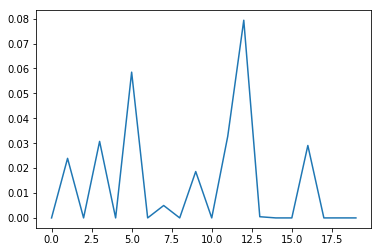

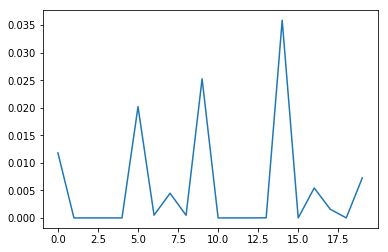

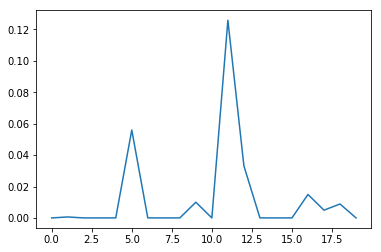

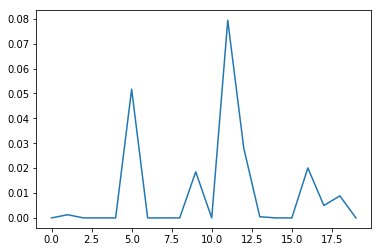

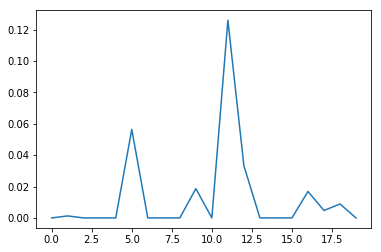

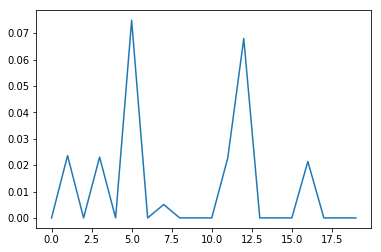

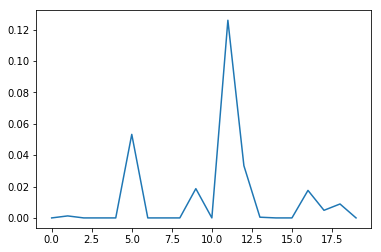

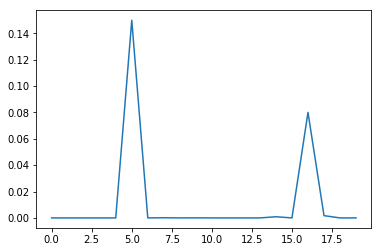

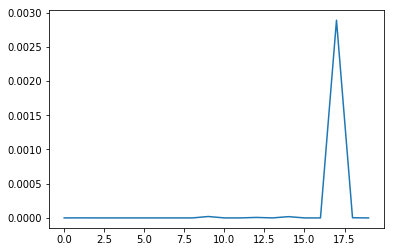

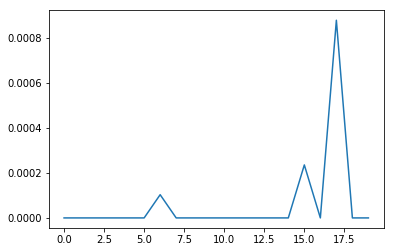

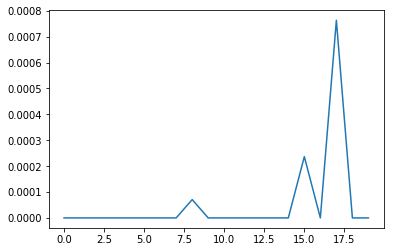

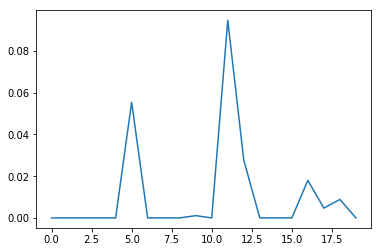

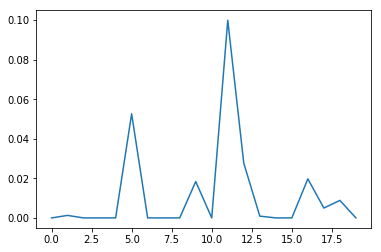

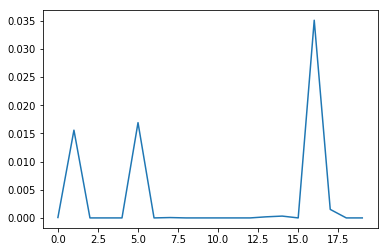

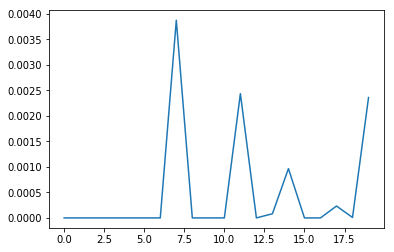

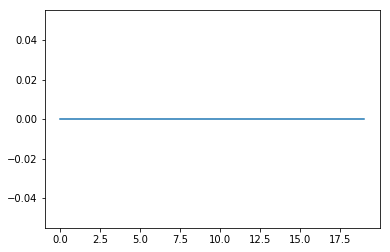

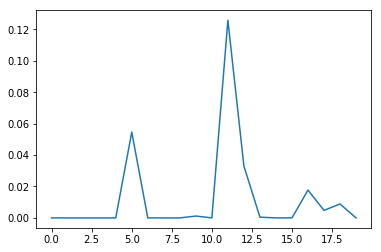

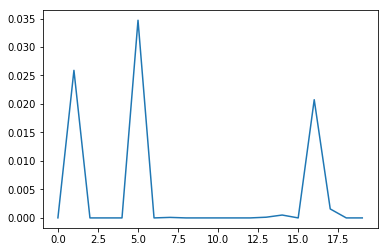

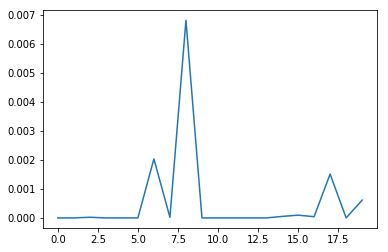

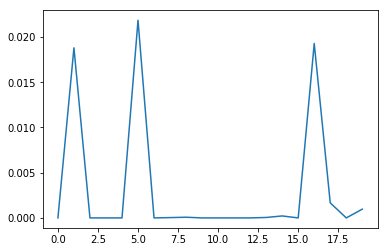

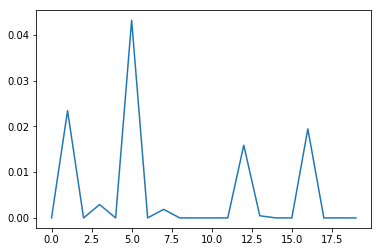

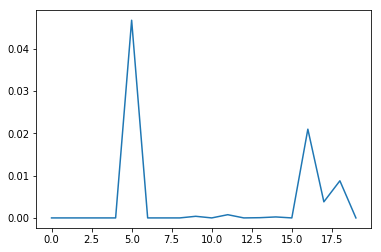

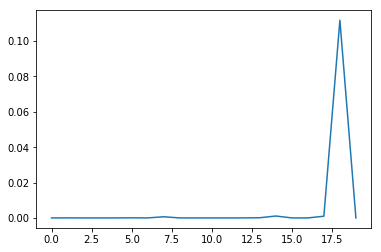

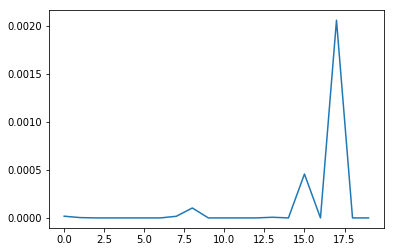

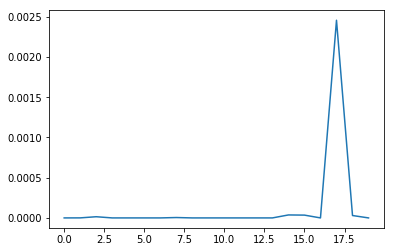

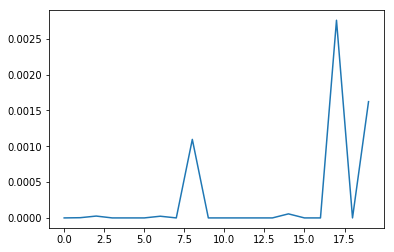

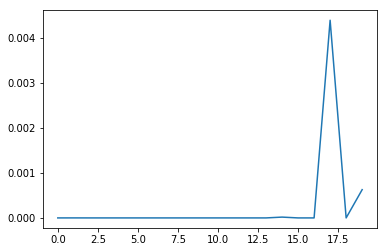

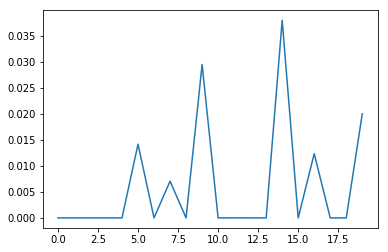

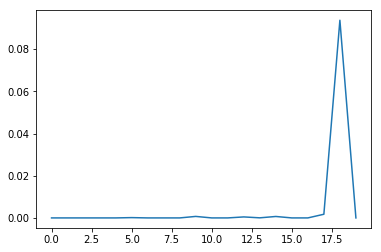

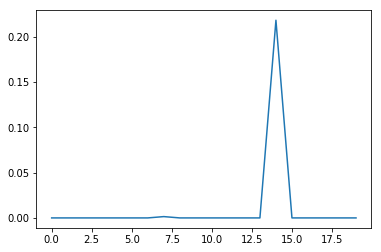

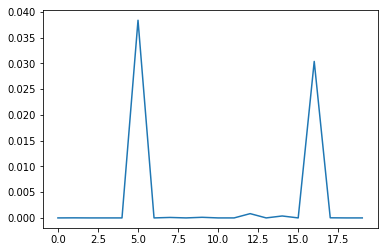

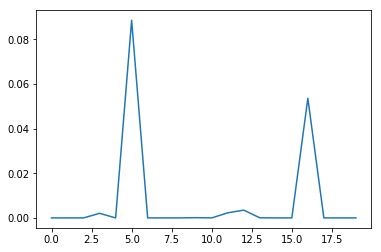

In [16]:
for i in P:
    plt.figure()
    plt.plot(i)
    plt.show()

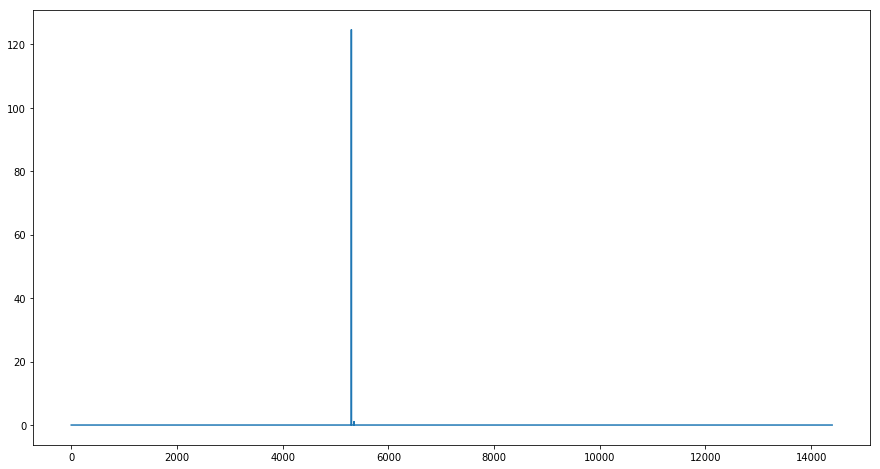

Feature: 0
Threshold : 3.124838112016145
{Timestamp('2012-04-04 00:00:00', freq='D')}



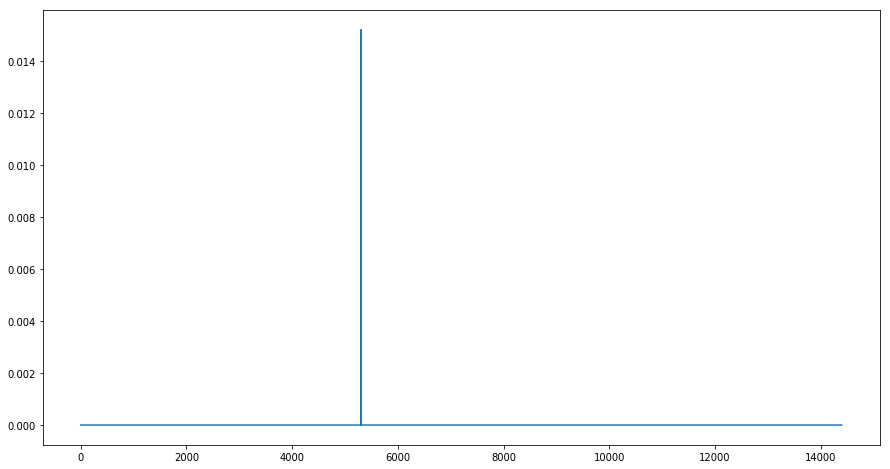

Feature: 1
Threshold : 0.0005209784831413733
{Timestamp('2012-04-04 00:00:00', freq='D')}



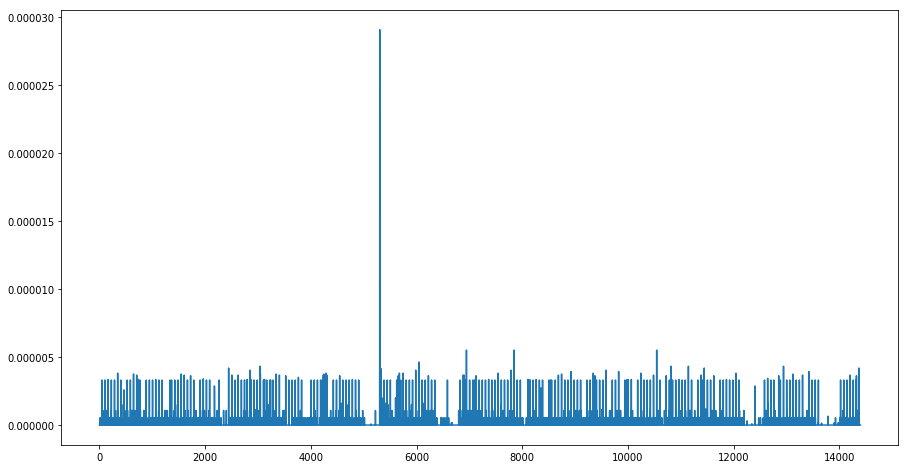

Feature: 2
Threshold : 1.76461664529253e-06
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-07 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-08 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



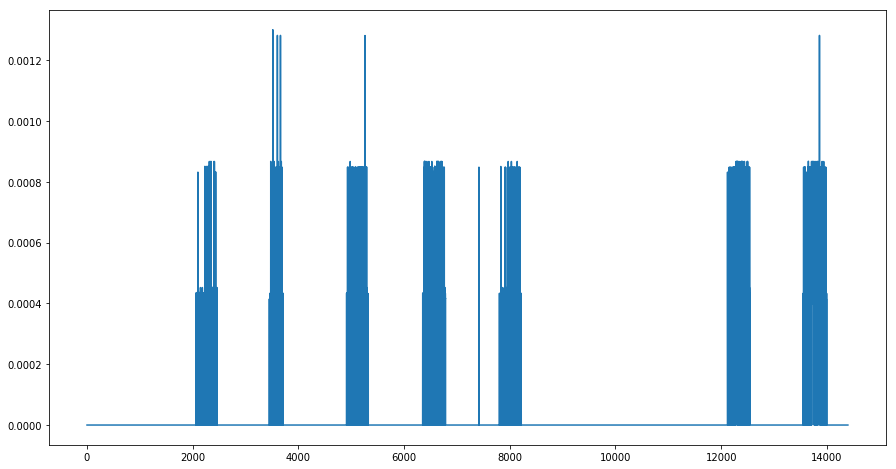

Feature: 3
Threshold : 0.0005599884771384828
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D')}



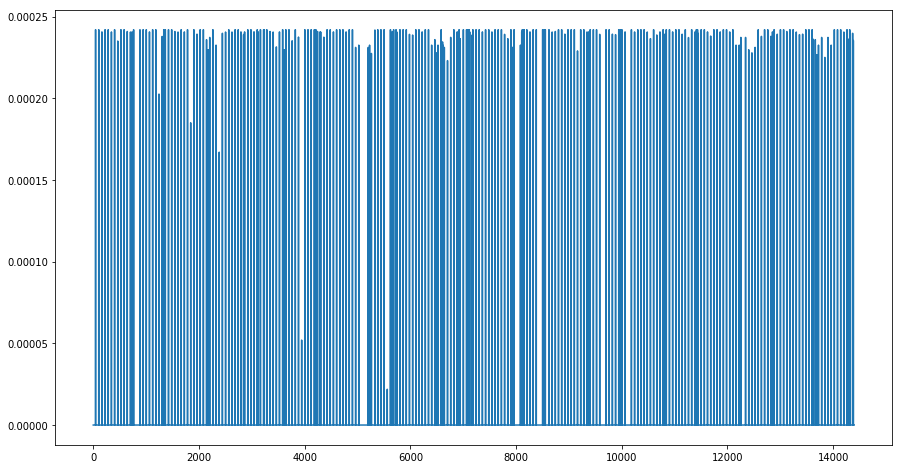

Feature: 4
Threshold : 0.00010355717866280442
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-07 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-08 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



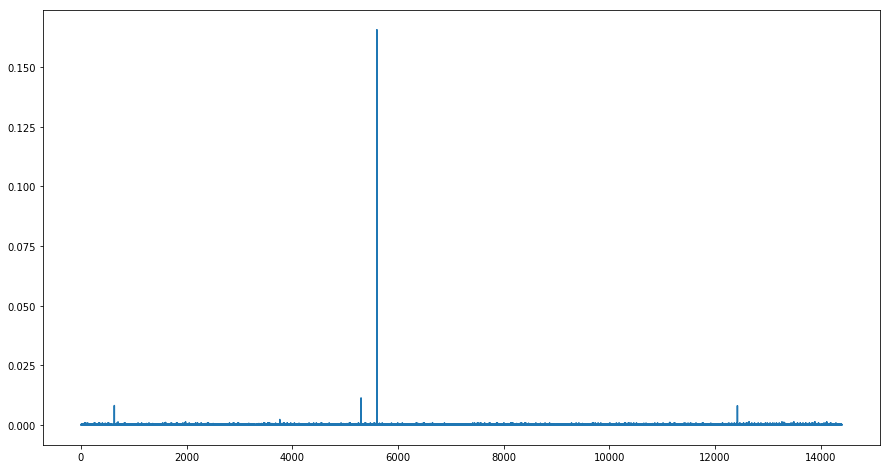

Feature: 5
Threshold : 0.004289804134856435
{Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



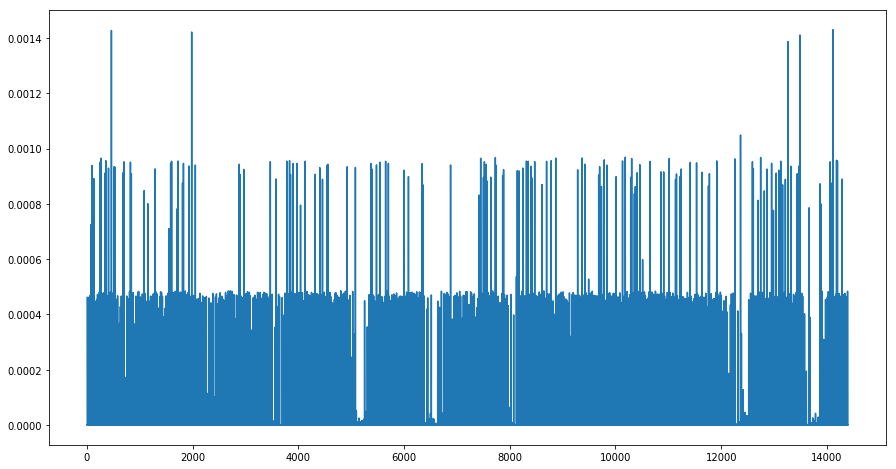

Feature: 6
Threshold : 0.00044159195050756146
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-07 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-08 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



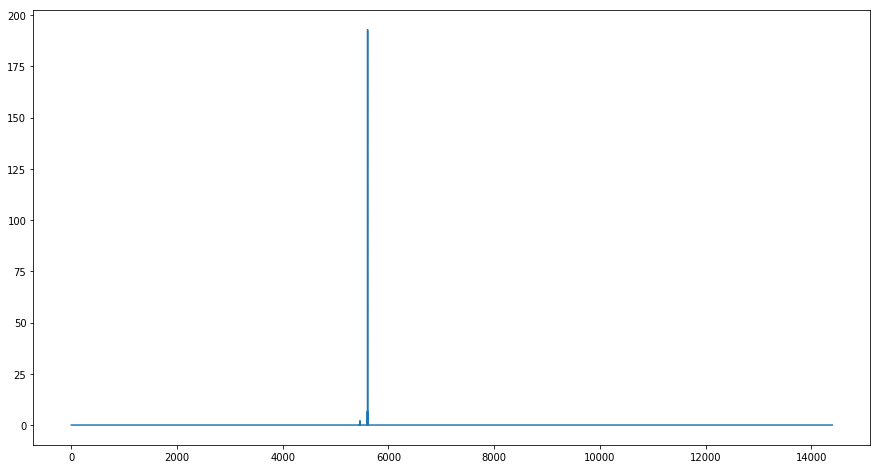

Feature: 7
Threshold : 4.841257736554134
{Timestamp('2012-04-04 00:00:00', freq='D')}



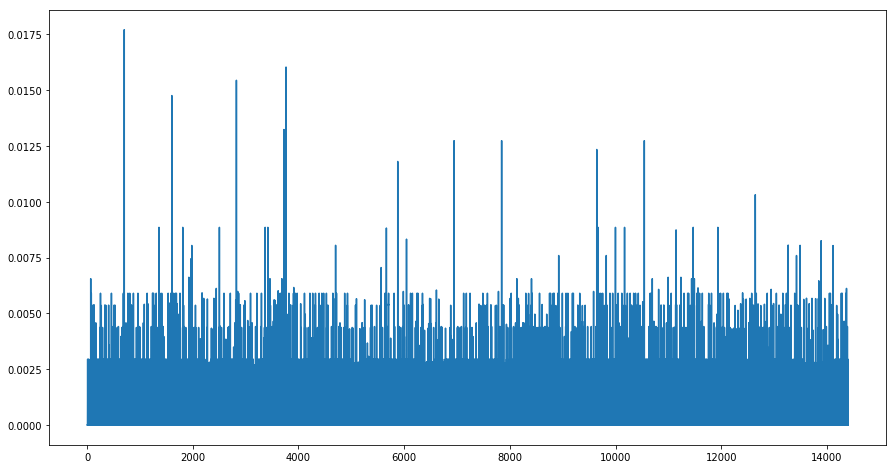

Feature: 8
Threshold : 0.005174779806572931
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-07 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-08 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



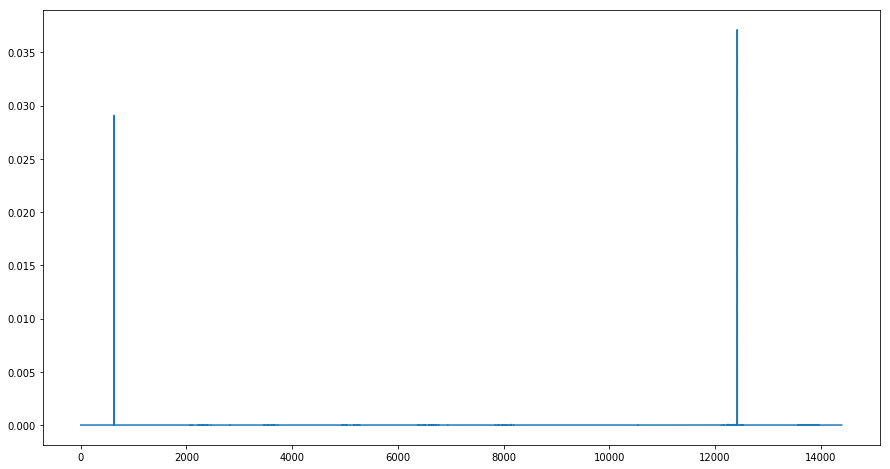

Feature: 9
Threshold : 0.0011843999561788278
{Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



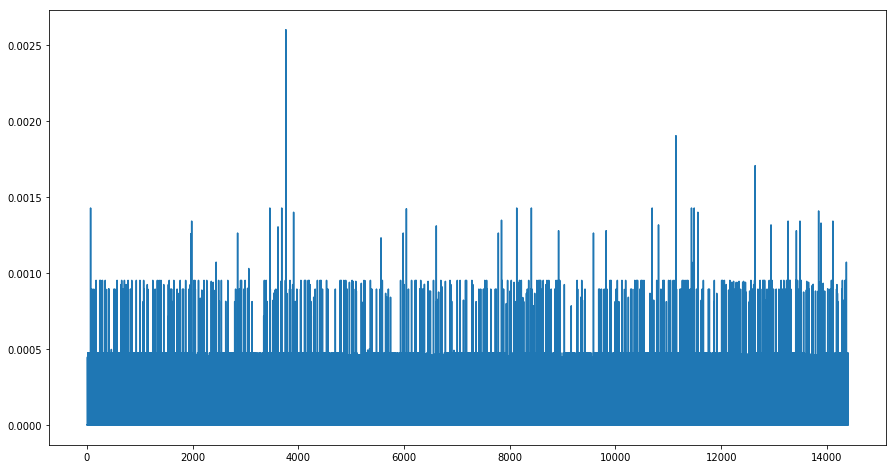

Feature: 10
Threshold : 0.0007434938724454377
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-07 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-08 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



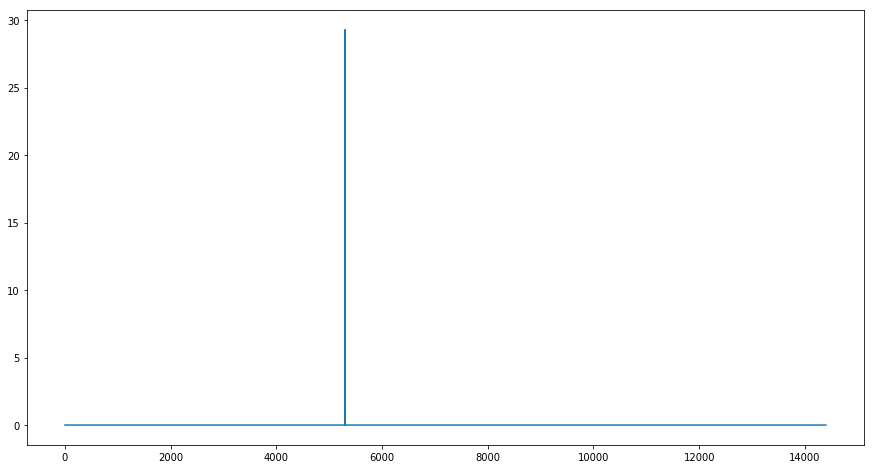

Feature: 11
Threshold : 0.7341504098610064
{Timestamp('2012-04-04 00:00:00', freq='D')}



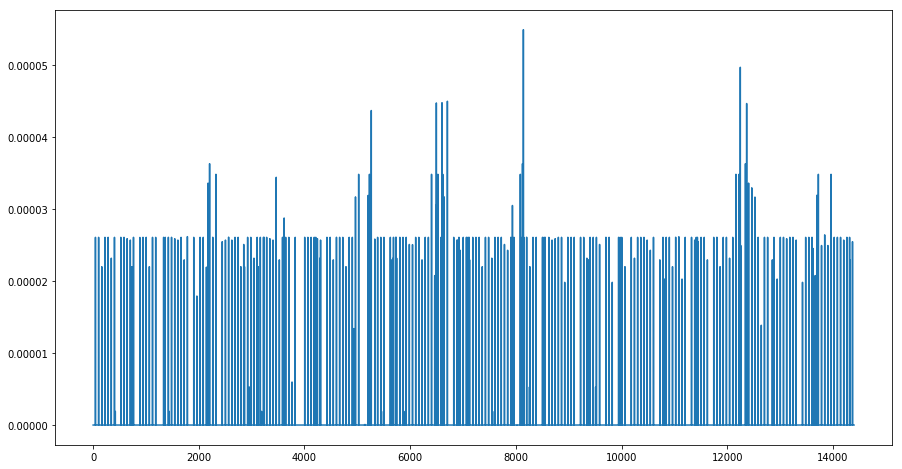

Feature: 12
Threshold : 1.1270091458778961e-05
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-07 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-08 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



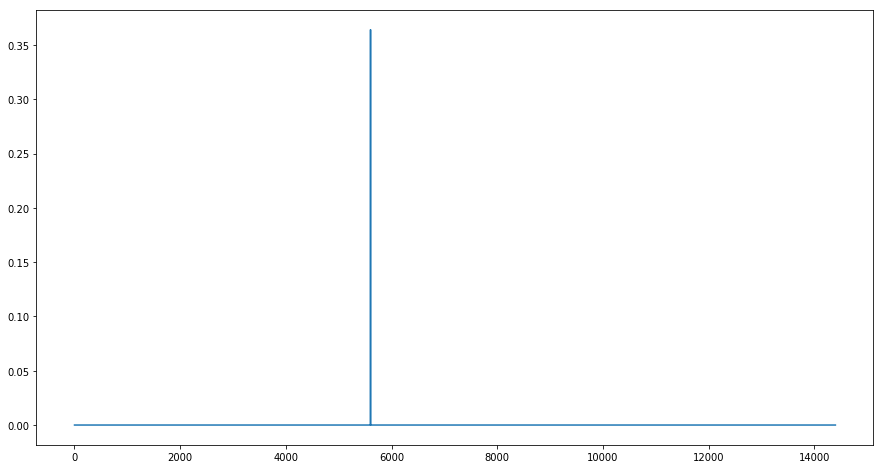

Feature: 13
Threshold : 0.009131407901523725
{Timestamp('2012-04-04 00:00:00', freq='D')}



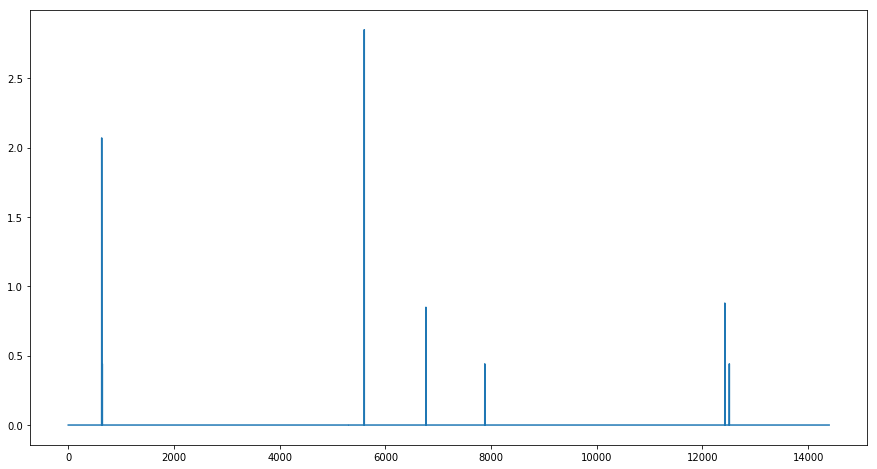

Feature: 14
Threshold : 0.09693974834622514
{Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



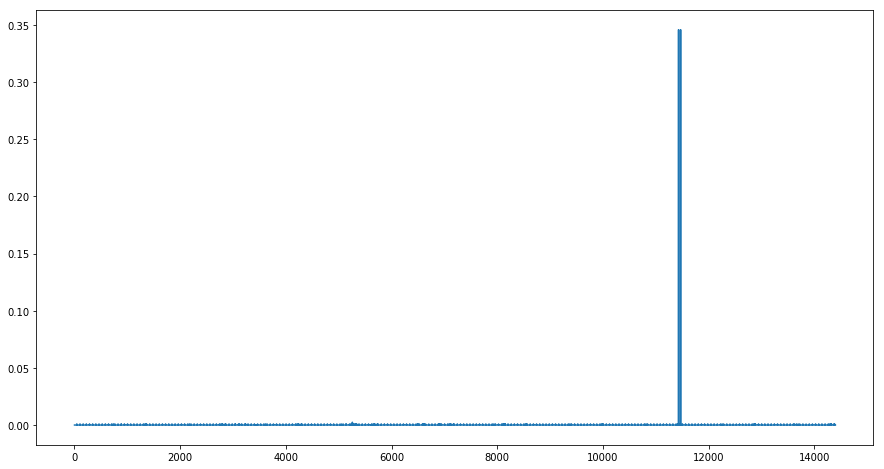

Feature: 15
Threshold : 0.01230957250234649
{Timestamp('2012-04-08 00:00:00', freq='D')}



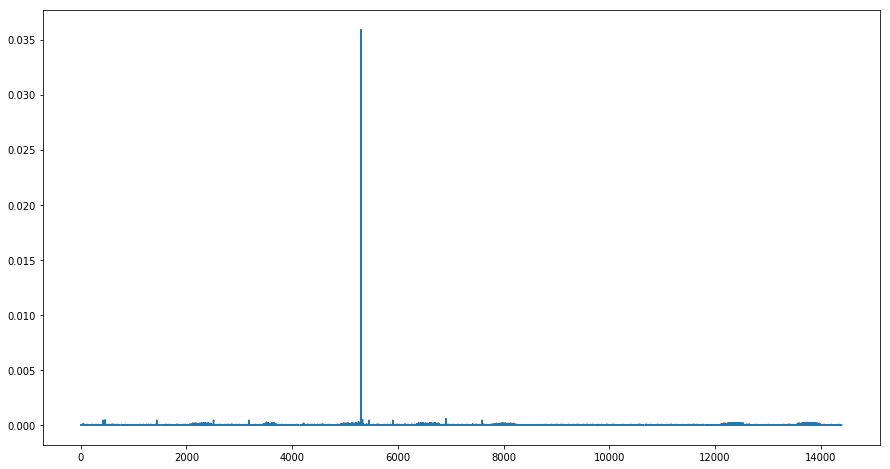

Feature: 16
Threshold : 0.0010456553600751667
{Timestamp('2012-04-04 00:00:00', freq='D')}



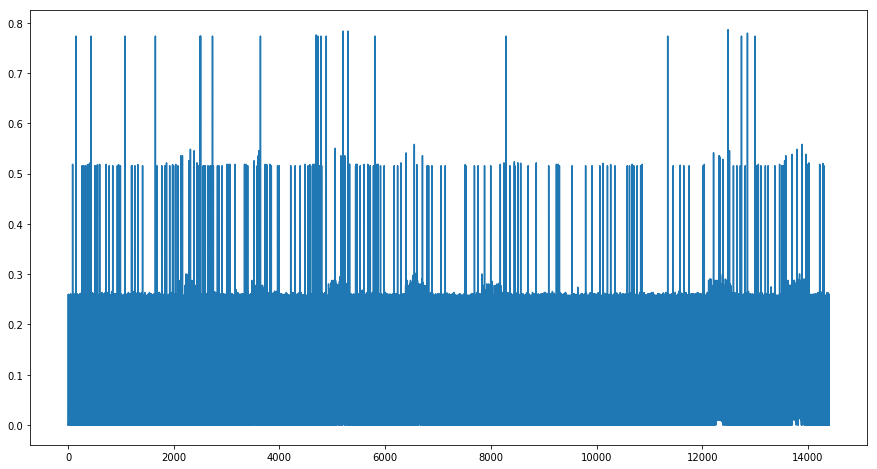

Feature: 17
Threshold : 0.3559482582493847
{Timestamp('2012-04-02 00:00:00', freq='D'), Timestamp('2012-04-03 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D'), Timestamp('2012-04-10 00:00:00', freq='D'), Timestamp('2012-04-09 00:00:00', freq='D'), Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-07 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-08 00:00:00', freq='D'), Timestamp('2012-04-01 00:00:00', freq='D')}



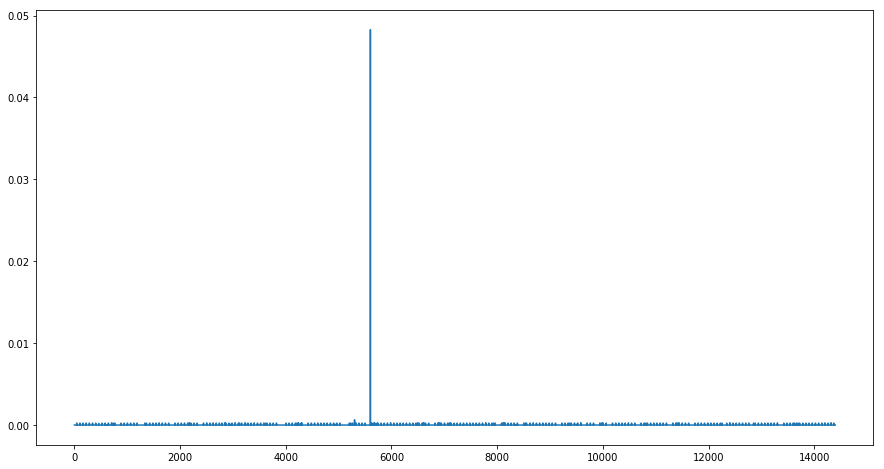

Feature: 18
Threshold : 0.0012187295108970144
{Timestamp('2012-04-04 00:00:00', freq='D')}



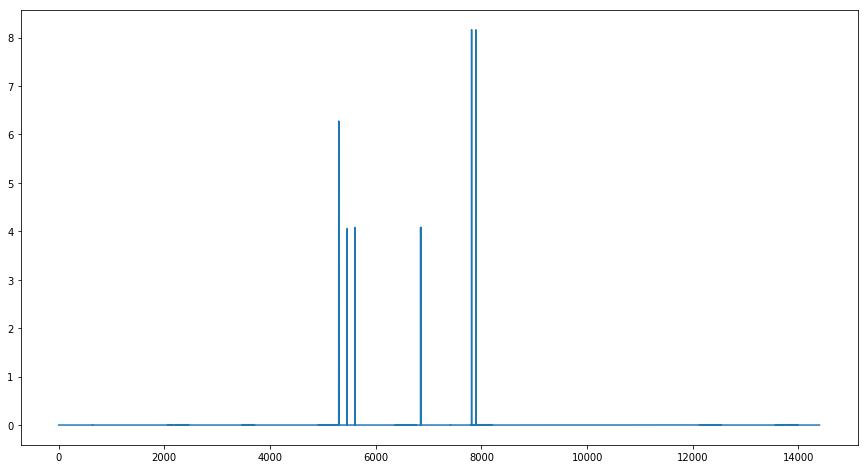

Feature: 19
Threshold : 0.4188303255004725
{Timestamp('2012-04-06 00:00:00', freq='D'), Timestamp('2012-04-05 00:00:00', freq='D'), Timestamp('2012-04-04 00:00:00', freq='D')}



In [31]:
date_index = []
for i in pd.date_range('20120401', '20130331'):
    date_index.extend([i]*1440)
date_index = np.array(date_index)
feat_id = 0
for i in Q[:, :14400]:
    plt.figure(figsize=(15, 8))
    plt.plot(i)
    plt.show()
    print("Feature:", feat_id)
    th = i.mean() + i.std() * 3
    print("Threshold :", th)
    anomaly = np.where(i - th > 0)[0]
    print(set(date_index[anomaly]))
    print()
    feat_id += 1